# Imports

In [7]:
import h5py

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD

import cv2
import skimage
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from umap import UMAP

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb


from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Charger un tableau NumPy à partir du fichier HDF5
with h5py.File('processed_data.h5', 'r') as hf:
    X_txt = hf['text'][:]
    X_img = hf['img'][:]
    y = hf['label'][:]

# Train / test splits

In [3]:
X_train_txt, X_val_txt, X_train_img, X_val_img, y_train, y_val = train_test_split(X_txt, X_img, y, 
                                                                                  test_size=0.2, 
                                                                                  random_state=0, 
                                                                                  stratify=y)


In [6]:
from imblearn.under_sampling import RandomUnderSampler

# Créer un index pour les échantillons d'entraînement
indices_train = np.arange(len(X_train_txt))

# Appliquer RandomUnderSampler aux deux ensembles de données
undersample = RandomUnderSampler(random_state=0)
indices_resampled, _ = undersample.fit_resample(indices_train.reshape(-1, 1), y_train)

# Utiliser les indices resamplés pour sélectionner les échantillons correspondants dans X_train_txt et X_train_img
X_train_txt_resampled = X_train_txt[indices_resampled.flatten()]
X_train_img_resampled = X_train_img[indices_resampled.flatten()]
y_train_resampled = y_train[indices_resampled.flatten()]

# Vérifier les nouvelles distributions de classes
print('Classes échantillon undersampled :', dict(pd.Series(y_train[indices_resampled.flatten()]).value_counts()))


Classes échantillon undersampled : {10: 489, 1920: 489, 2705: 489, 2585: 489, 2583: 489, 2582: 489, 2522: 489, 2462: 489, 2403: 489, 2280: 489, 2220: 489, 2060: 489, 1940: 489, 1560: 489, 40: 489, 1320: 489, 1302: 489, 1301: 489, 1300: 489, 1281: 489, 1280: 489, 1180: 489, 1160: 489, 1140: 489, 60: 489, 50: 489, 2905: 489}


# Preprocessing

## Images Preprocessing

In [8]:
# Classes de transformers

In [10]:
class GrayScaleConverter(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        #return np.array([skimage.color.rgb2gray(img) for img in X])
        return np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]).astype(int)


In [11]:
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(14,14),
                 cells_per_block=(2,2), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])
            

In [12]:
class HSVHistogram(BaseEstimator, TransformerMixin):
    def __init__(self, bins=256):
        self.bins = bins
    
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
        histograms = []
        for image in X:
            
            # Assurez-vous que l'image est en format flottant
            image = image.astype(np.float32)

            # Normaliser l'image pour obtenir des valeurs entre 0 et 1
            image /= 255.0

            # Diviser l'image en canaux de couleur
            channels = cv2.split(image)

            # Initialiser un histogramme vide pour chaque canal de couleur
            hist = []

            # Calculer l'histogramme pour chaque canal de couleur
            for channel in channels:
                hist_channel, _ = np.histogram(channel, bins=256, range=(0, 1))
                hist.append(hist_channel)

            # Concaténer les histogrammes de chaque canal pour obtenir l'histogramme global
            hist = np.concatenate(hist)
            histograms.append(hist)
            
        return np.array(histograms).astype(int)


In [13]:
class SIFTBoF(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=100):
        self.n_clusters = n_clusters
        self.kmeans = None

    def fit(self, X, y=None):
        sift = cv2.SIFT_create()

        # Extraire des descripteurs SIFT de toutes les images
        keypoints = []
        descriptors = []
        for image in X:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            kp, des = sift.detectAndCompute(gray, None)
            keypoints.extend(kp)
            if des is None:
                des = np.zeros(128).reshape(1, -1)
            else:
                des = des.astype('double') 
            descriptors.extend(des)

        # Regrouper les descripteurs en utilisant KMeans
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.kmeans.fit(descriptors)

        return self

    def transform(self, X):
        sift = cv2.SIFT_create()

        # Créer l'histogramme pour chaque image
        histograms = []
        for image in X:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            kp, des = sift.detectAndCompute(gray, None)
            if des is None:
                des = np.zeros(128).reshape(1, -1)
            else:
                des = des.astype('double') 
            labels = self.kmeans.predict(des)
            hist, _ = np.histogram(labels, bins=range(self.n_clusters + 1))
            histograms.append(hist)

        return np.array(histograms)
        

In [14]:
# 0. Image processing

processor_gray = GrayScaleConverter()
X_train_gray = processor_gray.fit_transform(X_train_img_resampled.reshape(-1, 100, 100, 3)) / 255.0
X_val_gray = processor_gray.transform(X_val_img.reshape(-1, 100, 100, 3)) / 255.0

#processor_hog = HogTransformer()
#X_train_hog = processor_hog.fit_transform(X_train_gray)
#X_val_hog = processor_hog.transform(X_val_gray)

#processor = CannyEdgeDetector()
#X_train_canny = processor.transform(X_train_gray)

#processor = LaplacianFilter()
#X_train_laplacian = processor.transform(X_train_gray)

processor_hsv = HSVHistogram()
X_train_hsv = processor_hsv.fit_transform(X_train_img_resampled.reshape(-1, 100, 100, 3))
X_val_hsv = processor_hsv.transform(X_val_img.reshape(-1, 100, 100, 3))

#processor_bof = SIFTBoF(n_clusters=500)
#X_train_bof = processor_bof.fit_transform(X_train_img_resampled.reshape(-1, 100, 100, 3))
#X_val_bof = processor_bof.transform(X_val_img.reshape(-1, 100, 100, 3))


In [15]:
#UMAP
umap_model = UMAP(n_components=500)
X_train_img_reduced = umap_model.fit_transform(X_train_gray.reshape(-1, 10000))
X_val_img_reduced = umap_model.transform(X_val_gray.reshape(-1, 10000))


In [16]:
# 1. on combine les features images
X_train_img_comb = np.concatenate((X_train_gray.reshape(-1, 10000), X_train_hsv), axis=1)
X_val_img_comb = np.concatenate((X_val_gray.reshape(-1, 10000), X_val_hsv), axis=1)

# 2. Feature Scaling min max
#scaler = MinMaxScaler()
#X_train_img_comb_sc = scaler.fit_transform(X_train_img_comb)
#X_val_img_comb_sc = scaler.transform(X_val_img_comb)
                                  

## Text Preprocessing

In [17]:
# 1. Vecteur TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train_txt_resampled)
X_val_tfidf = vectorizer.transform(X_val_txt)

# 2. Réduction de dimensionnalité avec SVD
svd = TruncatedSVD(n_components=1000)   # Choisir le nombre de composants souhaités
X_train_txt_reduced = svd.fit_transform(X_train_tfidf)
X_val_txt_reduced = svd.transform(X_val_tfidf)

# 3. Feature Scaling min max
#scaler = MinMaxScaler()
#X_train_txt_reduced_sc = scaler.fit_transform(X_train_txt_reduced)
#X_val_txt_reduced_sc = scaler.transform(X_val_txt_reduced)


## Combine Preprocessing

In [18]:
# on choisit les features
X_train_combined = np.concatenate((X_train_txt_reduced, X_train_img_reduced), axis=1)
X_val_combined = np.concatenate((X_val_txt_reduced, X_val_img_reduced), axis=1)


# Text & Image combined Models

## Dummy Classifier

In [64]:
%%time
clf = DummyClassifier()
clf.fit(X_train_combined, y_train_resampled)
print(f"accuracy : {clf.score(X_val_combined, y_val)}\n")

accuracy : 0.03672628247589608

CPU times: total: 0 ns
Wall time: 5.85 ms


## Multinomial Naive Bayes

In [67]:
%%time
clf = MultinomialNB()
clf.fit(X_train_combined, y_train_resampled)
print(f"accuracy : {clf.score(X_val_combined, y_val)}\n")

accuracy : 0.12695959372930007

CPU times: total: 1.28 s
Wall time: 782 ms


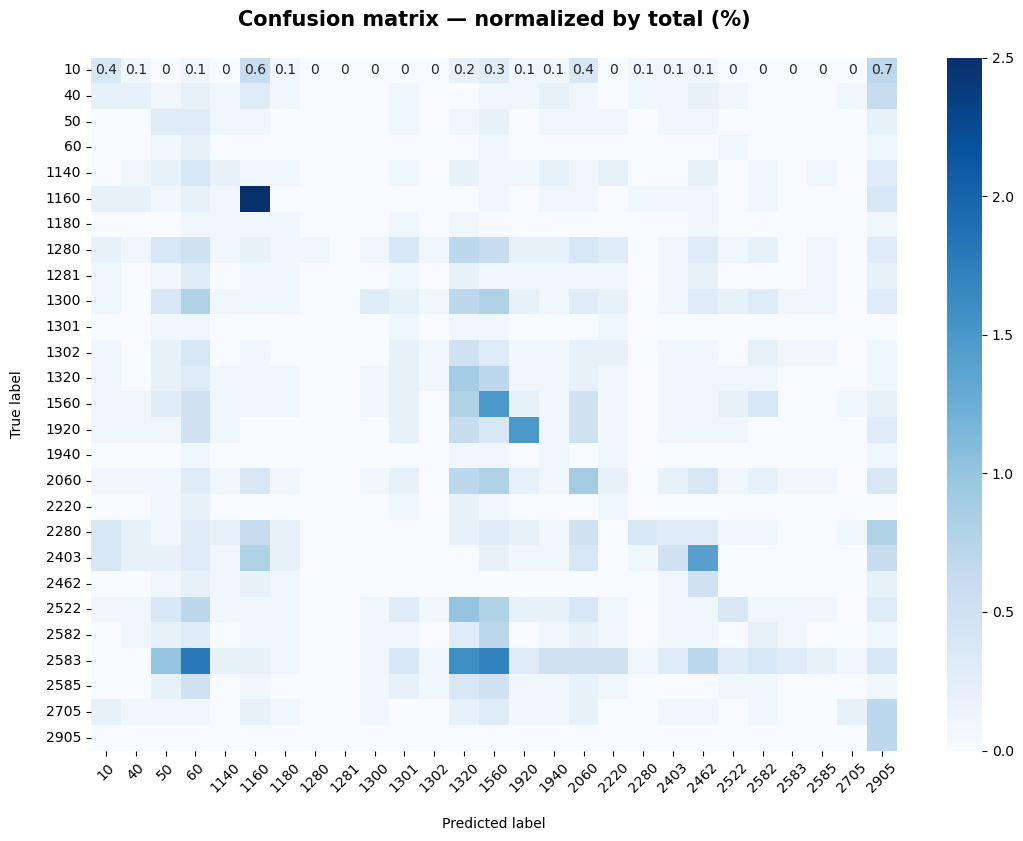

In [69]:
y_pred = clf.predict(X_val_combined)
cm = confusion_matrix(y_val, y_pred)
cm = np.round(cm / cm.sum() *100, 1)
labels = np.unique(y_val)

fig, ax = plt.subplots(figsize=(13, 9))
plt.title('Confusion matrix — normalized by total (%)\n', fontsize=15, fontweight = 'bold')
ax = sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
plt.xticks(rotation=45)
ax.set(xlabel='\nPredicted label', ylabel='True label\n');

## Random Forest

In [70]:
%%time
rf = RandomForestClassifier()
rf.fit(X_train_combined, y_train_resampled)
print(f"accuracy : {rf.score(X_val_combined, y_val)}\n")

accuracy : 0.5244719216898506

CPU times: total: 5min 6s
Wall time: 5min 13s


In [71]:
y_pred_rf = rf.predict(X_val_combined)
cm = confusion_matrix(y_val, y_pred_rf)
cm_normalized_horizontally = np.round(cm / cm.sum(axis=1) *100, 1)
cm_normalized_vertically = np.round(cm / cm.sum(axis=0) *100, 1)
cm_normalized = np.round(cm / cm.sum() *100, 1)
labels = np.unique(y_val)

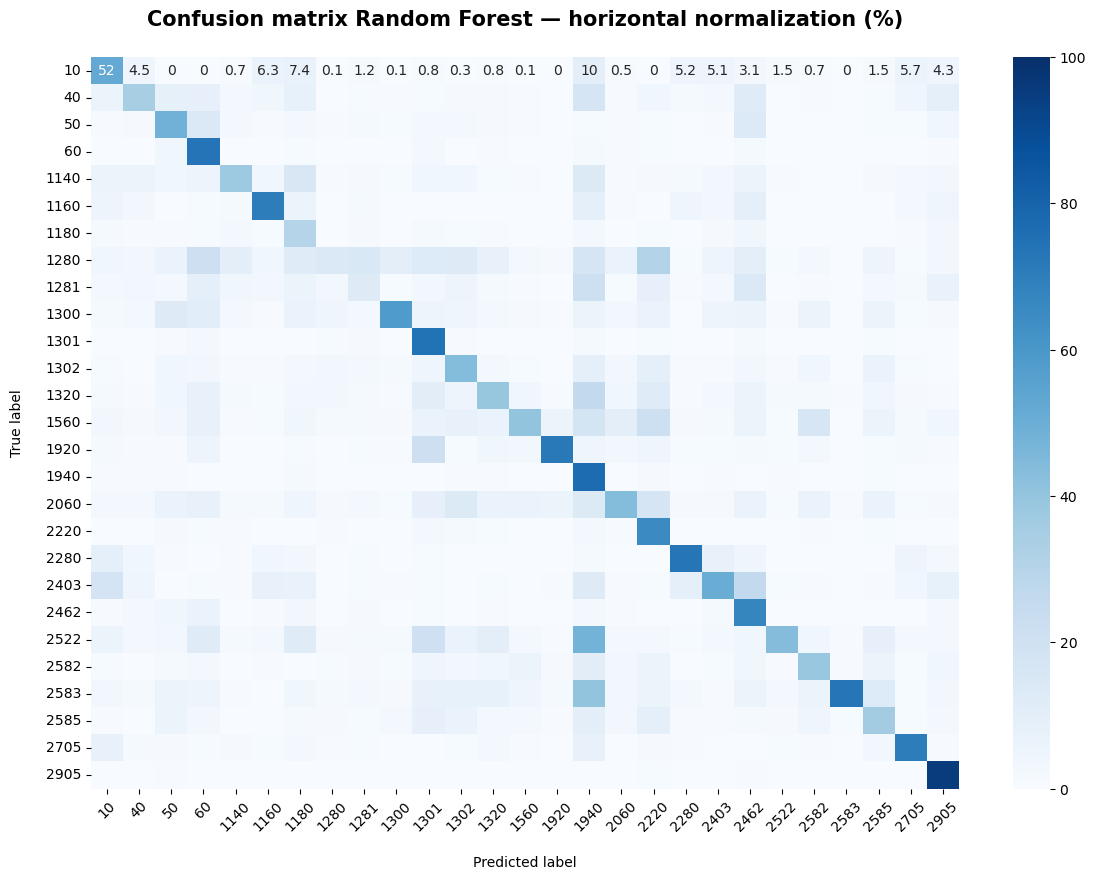

In [72]:
# Confusion matrix with horizontal normalization
fig, ax = plt.subplots(figsize=(14, 9.5))
plt.title('Confusion matrix Random Forest — horizontal normalization (%)\n', fontsize=15, fontweight = 'bold')
sns.heatmap(data=cm_normalized_horizontally, vmin=0, vmax=100, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
plt.xticks(rotation=45)
ax.set(xlabel='\nPredicted label', ylabel='True label\n');

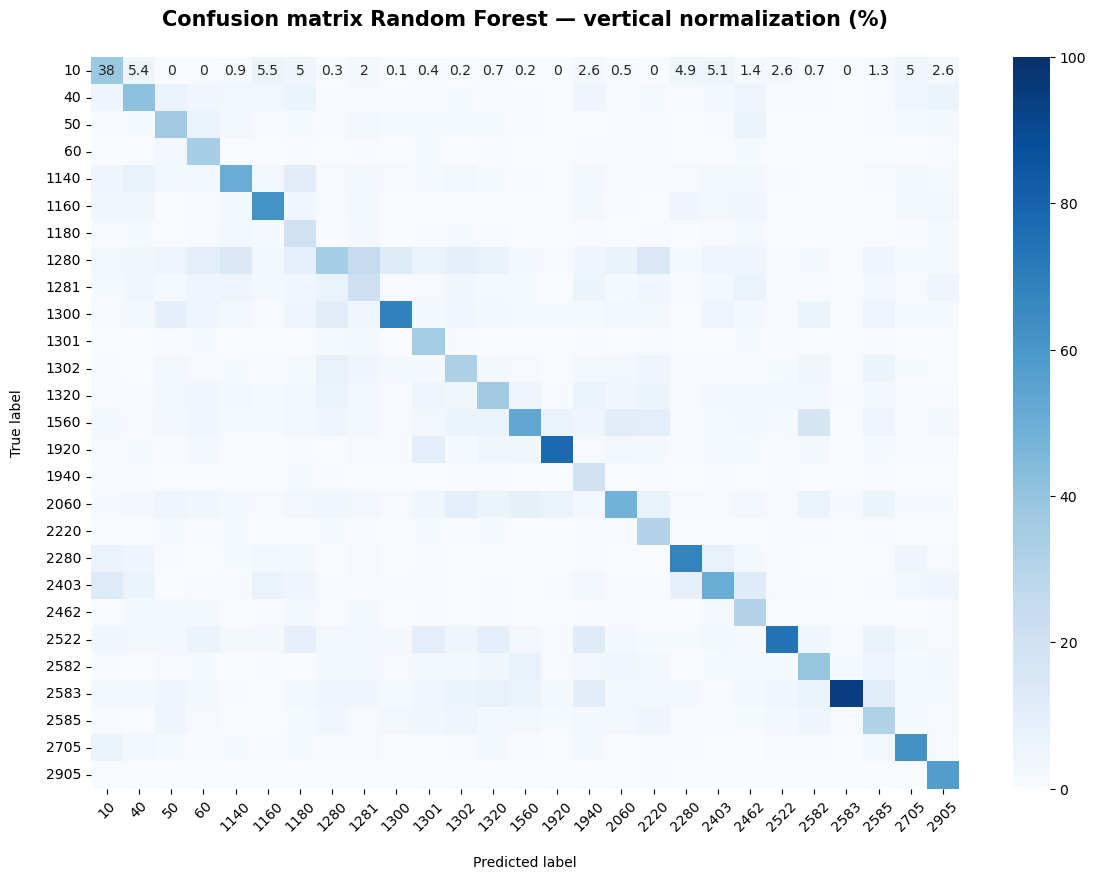

In [73]:
# Confusion matrix with vertical normalization
fig, ax = plt.subplots(figsize=(14, 9.5))
plt.title('Confusion matrix Random Forest — vertical normalization (%)\n', fontsize=15, fontweight = 'bold')
sns.heatmap(data=cm_normalized_vertically, vmin=0, vmax=100, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
plt.xticks(rotation=45)
ax.set(xlabel='\nPredicted label', ylabel='True label\n');

In [ ]:
%%time
clf = AdaBoostClassifier(algorithm='SAMME')
clf.fit(X_train_5pct, y_train_5pct)
clf.score(X_val_5pct, y_val_5pct)

Trop long > j'arrête l'essai.

## LightGBM

In [104]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled.reshape(-1, 1))
y_val_enc = label_encoder.transform(y_val.reshape(-1, 1))


train_data = lgb.Dataset(X_train_combined, label=y_train_enc)
val_data = lgb.Dataset(X_val_combined, label=y_val_enc)


max_depth = 3
num_leaves = 2 ** max_depth  # 2^max_depth = 32 > 31

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 27,
    'learning_rate': 0.1,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_child_samples': 20,
    'is_unbalance' : True,
    'n_estimators':1000,
    'metric': ['multi_logloss', 'multi_error', 'auc_mu']

}

# Définition des callbacks
callbacks = [
    lgb.early_stopping(
        stopping_rounds=20,
        verbose=False
    )
]

# Entraînement du modèle avec early stopping
model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks,
    num_boost_round=500)



C:\Users\Nans\miniconda3\envs\rakuten\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Nans\miniconda3\envs\rakuten\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
C:\Users\Nans\miniconda3\envs\rakuten\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.370384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 637500
[LightGBM] [Info] Number of data points in the train set: 10125, number of used features: 2500
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[Ligh

In [109]:
# Faites des prédictions sur l'ensemble de test
y_pred_lgb = model.predict(X_val_combined, num_iteration=model.best_iteration)
y_pred_lgb = [np.argmax(pred) for pred in y_pred_lgb]

# Évaluez les performances du modèle
accuracy = accuracy_score(y_val_enc, y_pred_lgb)
print("Accuracy:", accuracy)

Accuracy: 0.7057481416059469


## SGD Classifier

In [79]:
%%time
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train_combined, y_train_resampled)
print(f"accuracy : {sgd.score(X_val_combined, y_val)}\n")

accuracy : 0.5244719216898506

CPU times: total: 5min 50s
Wall time: 6min


# Split Text & Images Models



## Random Forest

In [ ]:
# Images

In [19]:
%%time
rf_img = RandomForestClassifier(random_state=0)
rf_img.fit(X_train_img_comb, y_train_resampled)
print(f"accuracy : {rf_img.score(X_val_img_comb, y_val)}\n")


accuracy : 0.31787738279237504

CPU times: total: 5min 31s
Wall time: 5min 57s


In [20]:
# Texte

In [21]:
%%time
rf_txt = RandomForestClassifier(random_state=0)
rf_txt.fit(X_train_txt_reduced, y_train_resampled)
print(f"accuracy : {rf_txt.score(X_val_txt_reduced, y_val)}\n")


accuracy : 0.688672996246412

CPU times: total: 3min 27s
Wall time: 3min 49s


## SGD Classifier

In [22]:
# Images

In [23]:
%%time
sgd_img = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_img.fit(X_train_img_comb, y_train_resampled)
print(f"accuracy : {sgd_img.score(X_val_img_comb, y_val)}\n")

accuracy : 0.07536615882829174

CPU times: total: 11min 11s
Wall time: 11min 52s


In [24]:
# Texte

In [25]:
%%time
sgd_txt = SGDClassifier(max_iter=1000, tol=1e-3)
sgd_txt.fit(X_train_txt_reduced, y_train_resampled)
print(f"accuracy : {sgd_txt.score(X_val_txt_reduced, y_val)}\n")

accuracy : 0.7160521086332524

CPU times: total: 5.36 s
Wall time: 5.38 s


## light gbm

In [26]:
# Images

In [27]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled.reshape(-1, 1))
y_val_enc = label_encoder.transform(y_val.reshape(-1, 1))


train_data = lgb.Dataset(X_train_img_reduced, label=y_train_enc)
val_data = lgb.Dataset(X_val_img_reduced, label=y_val_enc)


max_depth = 3
num_leaves = 2 ** max_depth  # 2^max_depth = 32 > 31

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 27,
    'learning_rate': 0.1,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_child_samples': 20,
    'is_unbalance' : True,
    'n_estimators':1000,
    'metric': ['multi_logloss', 'multi_error', 'auc_mu']

}

# Définition des callbacks
callbacks = [
    lgb.early_stopping(
        stopping_rounds=20,
        verbose=False
    )
]

# Entraînement du modèle avec early stopping
lgb_img = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks,
    num_boost_round=500)

# Faites des prédictions sur l'ensemble de test
y_pred_lgb = lgb_img.predict(X_val_img_reduced, num_iteration=lgb_img.best_iteration)
y_pred_lgb = [np.argmax(pred) for pred in y_pred_lgb]

# Évaluez les performances du modèle
accuracy = accuracy_score(y_val_enc, y_pred_lgb)
print("Accuracy:", accuracy)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 13203, number of used features: 500
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[Light

In [28]:
# Texte

In [29]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_resampled.reshape(-1, 1))
y_val_enc = label_encoder.transform(y_val.reshape(-1, 1))


train_data = lgb.Dataset(X_train_txt_reduced, label=y_train_enc)
val_data = lgb.Dataset(X_val_txt_reduced, label=y_val_enc)


max_depth = 3
num_leaves = 2 ** max_depth  # 2^max_depth = 32 > 31

# Définition des paramètres du modèle
params = {
    'objective': 'multiclass',
    'num_class': 27,
    'learning_rate': 0.1,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'min_child_samples': 20,
    'is_unbalance' : True,
    'n_estimators':1000,
    'metric': ['multi_logloss', 'multi_error', 'auc_mu']

}

# Définition des callbacks
callbacks = [
    lgb.early_stopping(
        stopping_rounds=20,
        verbose=False
    )
]

# Entraînement du modèle avec early stopping
lgb_img = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=callbacks,
    num_boost_round=500)

# Faites des prédictions sur l'ensemble de test
y_pred_lgb = lgb_img.predict(X_val_txt_reduced, num_iteration=lgb_img.best_iteration)
y_pred_lgb = [np.argmax(pred) for pred in y_pred_lgb]

# Évaluez les performances du modèle
accuracy = accuracy_score(y_val_enc, y_pred_lgb)
print("Accuracy:", accuracy)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255000
[LightGBM] [Info] Number of data points in the train set: 13203, number of used features: 1000
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[LightGBM] [Info] Start training from score -3.295837
[Ligh